# Bot classifier

In [224]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.externals import joblib
from sklearn import model_selection, linear_model
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":24,"axes.titlesize":24,"axes.labelsize":24})   

import missingno as msno

In [225]:
full = pd.read_csv('data/full/train.csv')

In [226]:
full.target.value_counts()

0    6934
3    6312
2    5361
4    3661
1    2838
Name: target, dtype: int64

In [227]:
full.columns

Index(['avg_fav', 'avg_hash', 'avg_len', 'avg_ret', 'contributors_enabled',
       'created_at', 'default_profile', 'default_profile_image', 'description',
       'fake_words_score', 'favourites_count', 'follow_request_sent',
       'followers_count', 'following', 'freq', 'friends_count',
       'genuine_words_score', 'geo_enabled', 'is_translator', 'lang',
       'listed_count', 'location', 'max_fav', 'max_hash', 'max_len', 'max_ret',
       'media_perc', 'min_fav', 'min_hash', 'min_len', 'min_ret', 'name',
       'notifications', 'nsfw_avg', 'nsfw_profile', 'porn_words_score',
       'profile_background_color', 'profile_background_image_url',
       'profile_background_image_url_https', 'profile_background_tile',
       'profile_image_url', 'profile_image_url_https', 'profile_link_color',
       'profile_sidebar_border_color', 'profile_sidebar_fill_color',
       'profile_text_color', 'profile_use_background_image',
       'prop_words_score', 'protected', 'quote_perc', 'ret_perc',
  

## Data exploration

In [228]:
full.describe()

,avg_fav,avg_hash,avg_len,avg_ret,contributors_enabled,default_profile,default_profile_image,fake_words_score,favourites_count,follow_request_sent,...,ret_perc,spam_words_score,statuses_count,target,tweet_intradistance,url_intradistance,url_perc,user_id,utc_offset,verified
count,25106.000000,25106.000000,25106.000000,25106.000000,18281.0,22347.000000,18300.00000,25106.000000,25106.000000,18281.0,...,25106.000000,25106.000000,2.510600e+04,25106.000000,25106.000000,25106.000000,25106.000000,2.510600e+04,2810.000000,18292.000000
mean,6.701853,0.187896,56.958004,1480.894377,0.0,0.705956,0.04918,0.023929,5426.449892,0.0,...,0.233694,0.030912,1.073895e+04,1.877639,7.452426,1.922121,0.131263,1.637649e+17,-4889.145907,0.004702
std,462.762199,0.486488,52.017380,5434.678244,0.0,0.455622,0.21625,0.064130,25509.292286,0.0,...,0.350675,0.050025,4.146505e+04,1.427447,6.070453,2.619371,0.233282,3.576332e+17,22037.451204,0.068408
min,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,6.780330e+05,-39600.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0,...,0.000000,0.000000,2.100000e+01,0.000000,0.000000,0.000000,0.000000,3.985294e+08,-25200.000000,0.000000
50%,0.000000,0.040000,66.260000,0.040000,0.0,1.000000,0.00000,0.013060,70.000000,0.0,...,0.000000,0.014325,8.800000e+01,2.000000,10.614713,0.000000,0.000000,1.355739e+09,-14400.000000,0.000000
75%,0.090909,0.200000,91.000000,655.678750,0.0,1.000000,0.00000,0.026143,439.000000,0.0,...,0.468201,0.043146,2.585000e+03,3.000000,12.107880,3.394820,0.166667,2.811347e+09,13500.000000,0.000000
max,71540.120000,17.000000,308.000000,247147.066667,0.0,1.000000,1.00000,1.855191,913239.000000,0.0,...,1.000000,0.898990,1.418488e+06,4.000000,27.574898,10.090432,1.000000,1.036369e+18,46800.000000,1.000000


Delete naive features 

In [229]:
full = full.drop(columns=['contributors_enabled', 'follow_request_sent', 'following', 'profile_background_image_url', 'profile_background_image_url_https', 'profile_image_url', 'profile_image_url_https', 'time_zone', 'utc_offset'])

plot missing values

In [230]:
features = full.columns

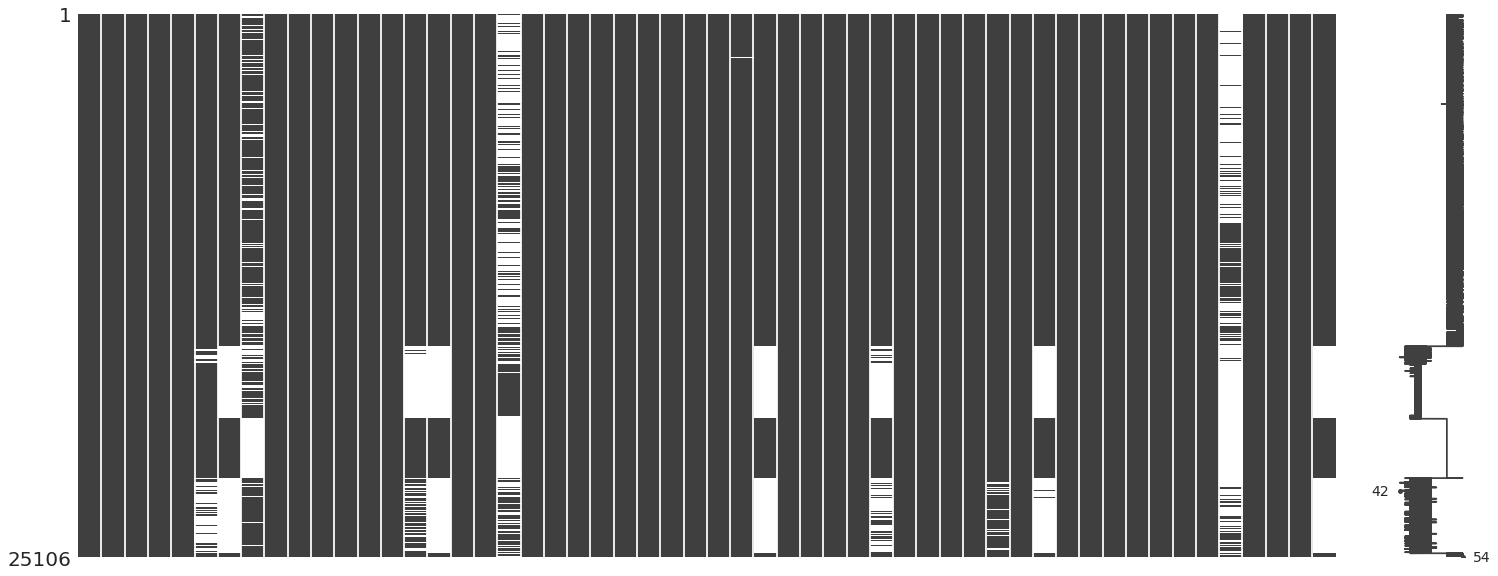

In [231]:
msno.matrix(full)

plot missing values for each target

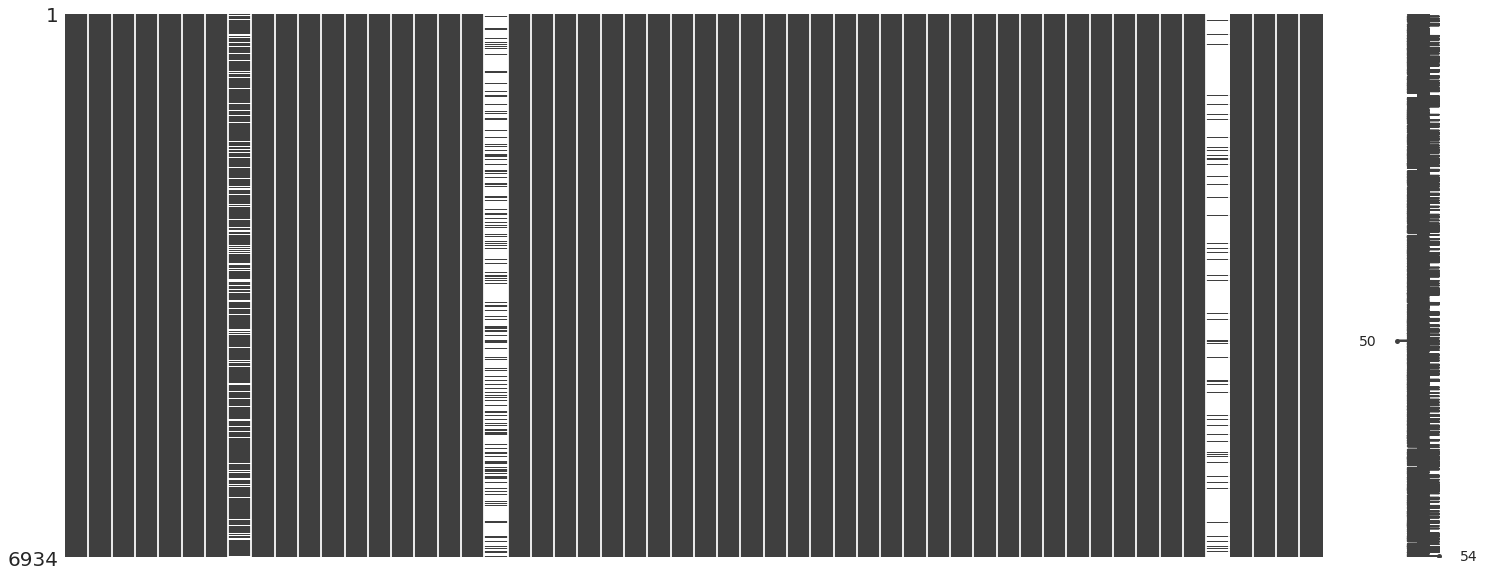

In [232]:
msno.matrix(full[full.target==0])

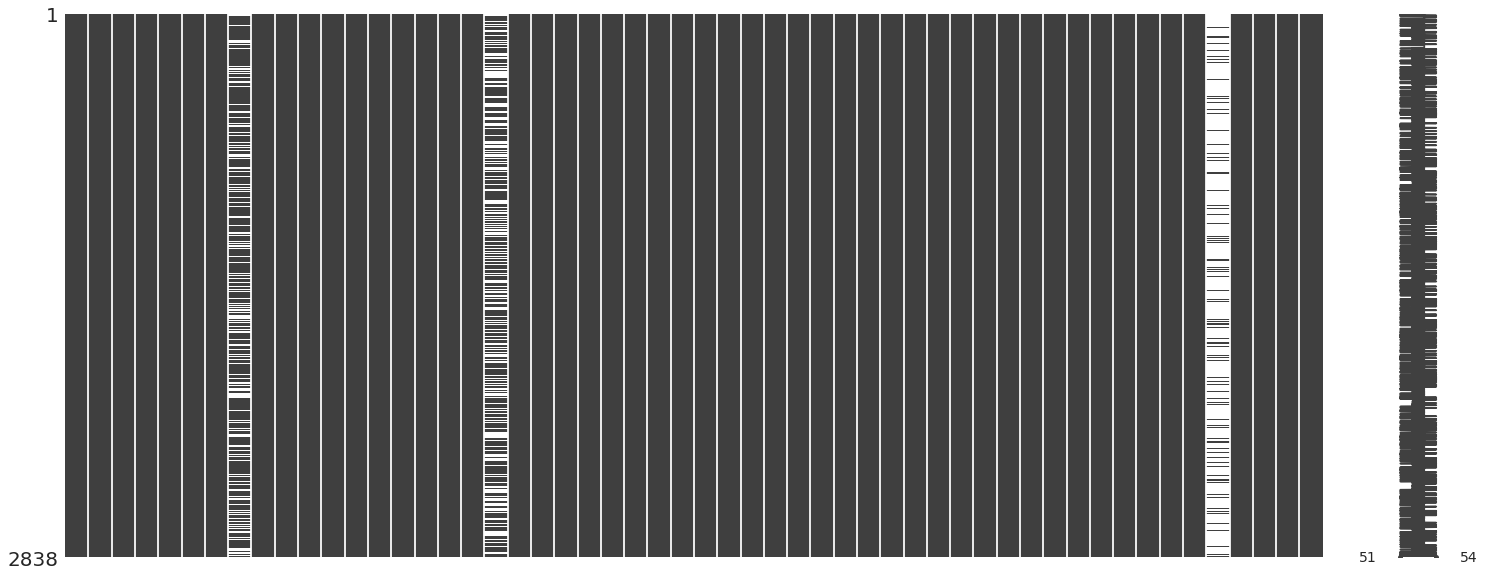

In [233]:
msno.matrix(full[full.target==1])

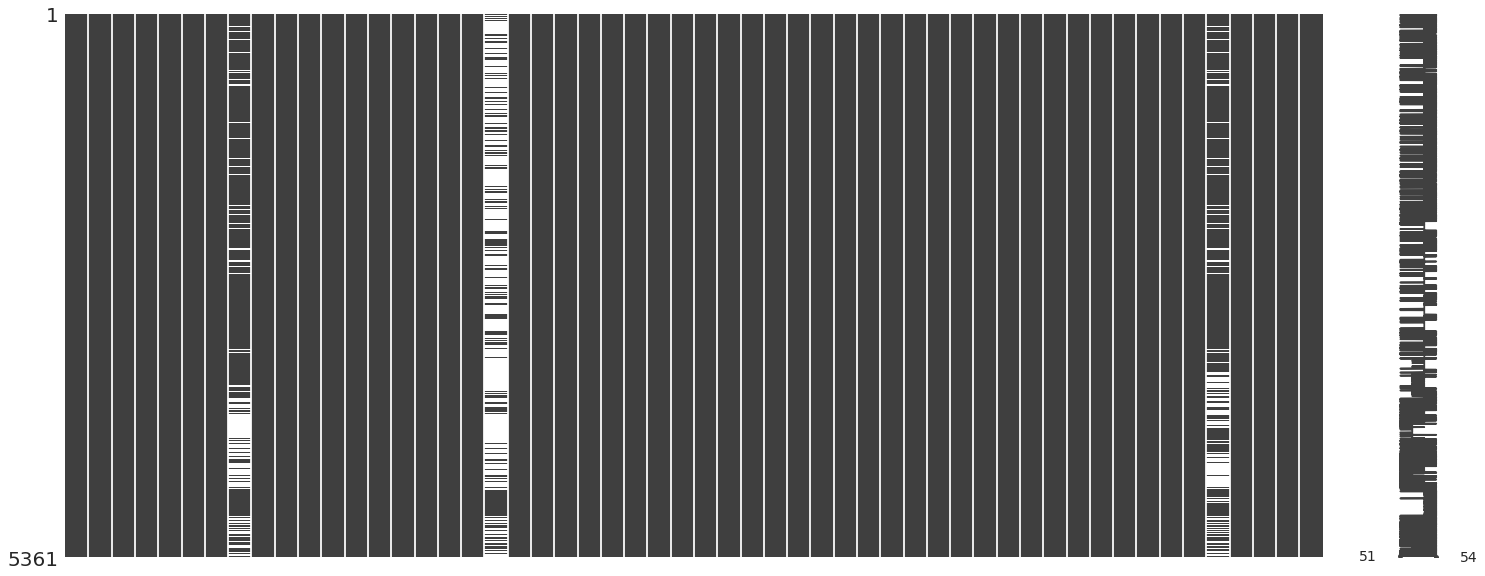

In [234]:
msno.matrix(full[full.target==2])

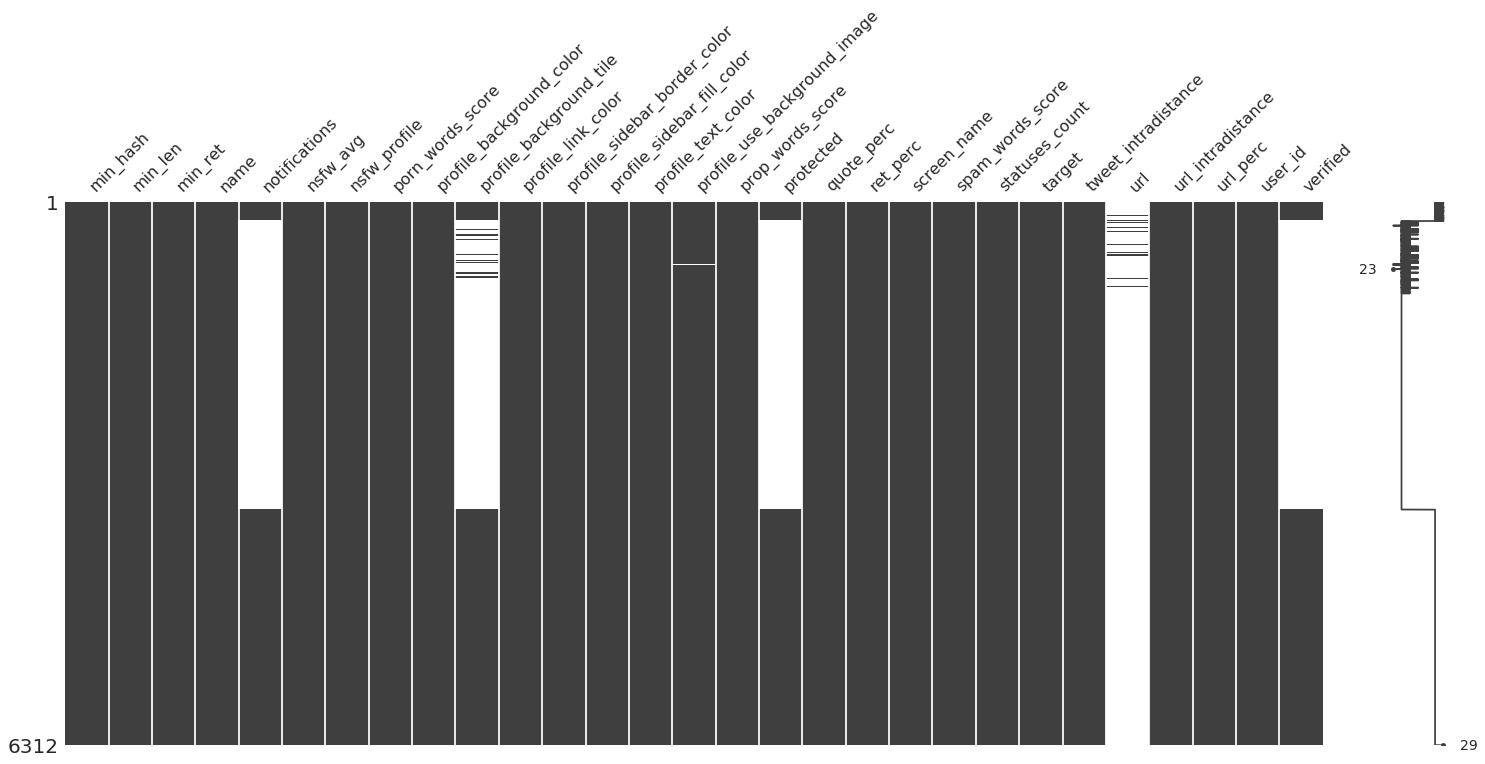

In [235]:
msno.matrix(full[full.target==3][features[25:]])

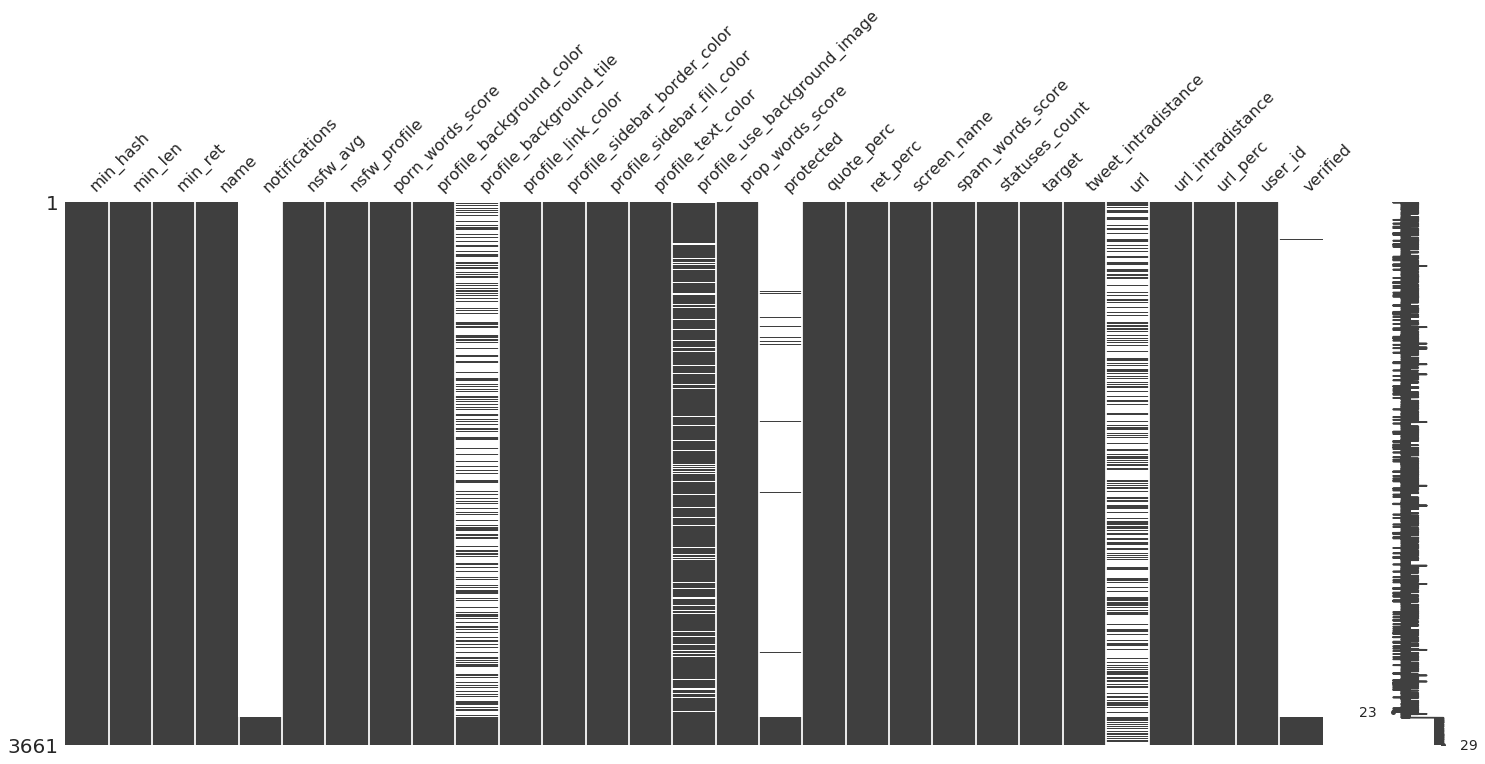

In [236]:
msno.matrix(full[full.target==4][features[25:]])

Remove features with too many missing values for some target

In [237]:
full = full.drop(columns=['default_profile_image','is_translator', 'geo_enabled', 'location', 'notifications', 'profile_background_tile', 'protected', 'verified'])

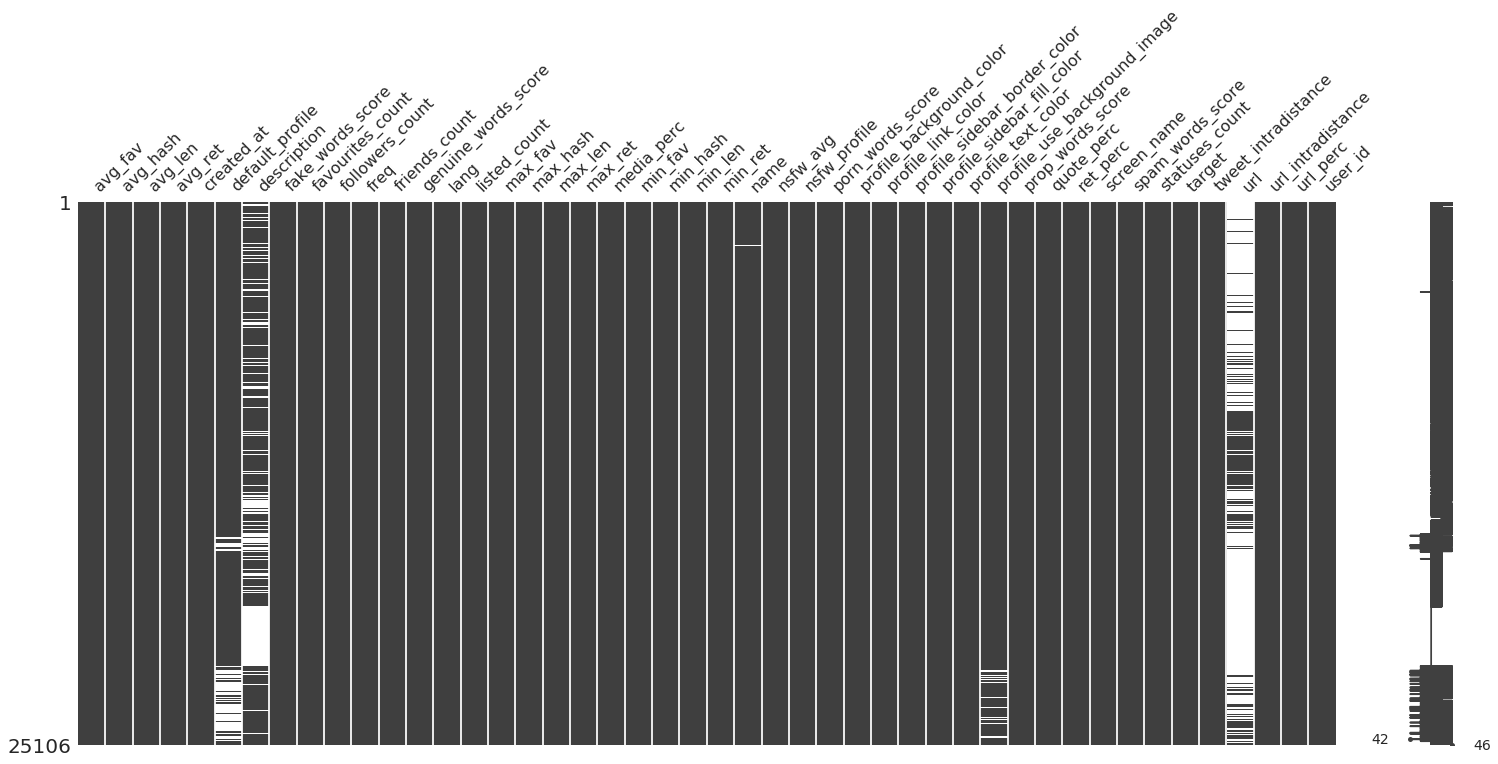

In [238]:
msno.matrix(full)

In [239]:
full.default_profile.describe()

count    22347.000000
mean         0.705956
std          0.455622
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: default_profile, dtype: float64

In [240]:
full[full.target==3].default_profile.describe()

count    5995.000000
mean        0.993328
std         0.081418
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: default_profile, dtype: float64

In [241]:
full[full.target==4].default_profile.describe()

count    1219.000000
mean        0.922888
std         0.266879
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: default_profile, dtype: float64

In [242]:
full['default_profile'] = full['default_profile'].fillna(full['default_profile'].mode()[0])

In [243]:
full['description'] = full['description'].fillna('')

In [244]:
full['description_len'] = full['description'].apply(lambda x: len(x))

In [245]:
full = full.drop(columns=['description'])

In [246]:
full['name'] = full['name'].fillna('')

In [247]:
full['name_len'] = full['name'].apply(lambda x: len(x))

In [248]:
full = full.drop(columns=['name'])

In [249]:
full['screen_name'] = full['screen_name'].fillna('')

In [250]:
full['screen_name_len'] = full['screen_name'].apply(lambda x: len(x))

In [251]:
full = full.drop(columns=['screen_name'])

In [252]:
full = full.drop(columns=['lang'])

In [253]:
def oldness(x):
    if x[0] == '2':
        return 2018 - int(x[:4])
    else:
        return 2018 - int(x[-4:])

In [254]:
full['age'] = full['created_at'].apply(lambda x: oldness(x))

In [255]:
full = full.drop(columns=['created_at'])

In [256]:
# full = full.drop(columns=['user_id'])

In [257]:
full['profile_use_background_image'][full.target==4].value_counts()

1.0    3246
0.0      25
Name: profile_use_background_image, dtype: int64

In [258]:
full['profile_use_background_image'] = full['profile_use_background_image'].fillna(full['profile_use_background_image'].mode()[0])

In [259]:
full['url'] = (full['url'].notnull()).astype(int)

In [260]:
full['profile_use_background_image'] = full['profile_use_background_image'].fillna(full['profile_use_background_image'].mode()[0])

In [261]:
full['profile_use_background_image'] = full['profile_use_background_image'].fillna(full['profile_use_background_image'].mode()[0])

verifico che non ci siano più missing values

In [262]:
full.isnull().astype(int).sum()

avg_fav                         0
avg_hash                        0
avg_len                         0
avg_ret                         0
default_profile                 0
fake_words_score                0
favourites_count                0
followers_count                 0
freq                            0
friends_count                   0
genuine_words_score             0
listed_count                    0
max_fav                         0
max_hash                        0
max_len                         0
max_ret                         0
media_perc                      0
min_fav                         0
min_hash                        0
min_len                         0
min_ret                         0
nsfw_avg                        0
nsfw_profile                    0
porn_words_score                0
profile_background_color        0
profile_link_color              0
profile_sidebar_border_color    0
profile_sidebar_fill_color      0
profile_text_color              0
profile_use_ba

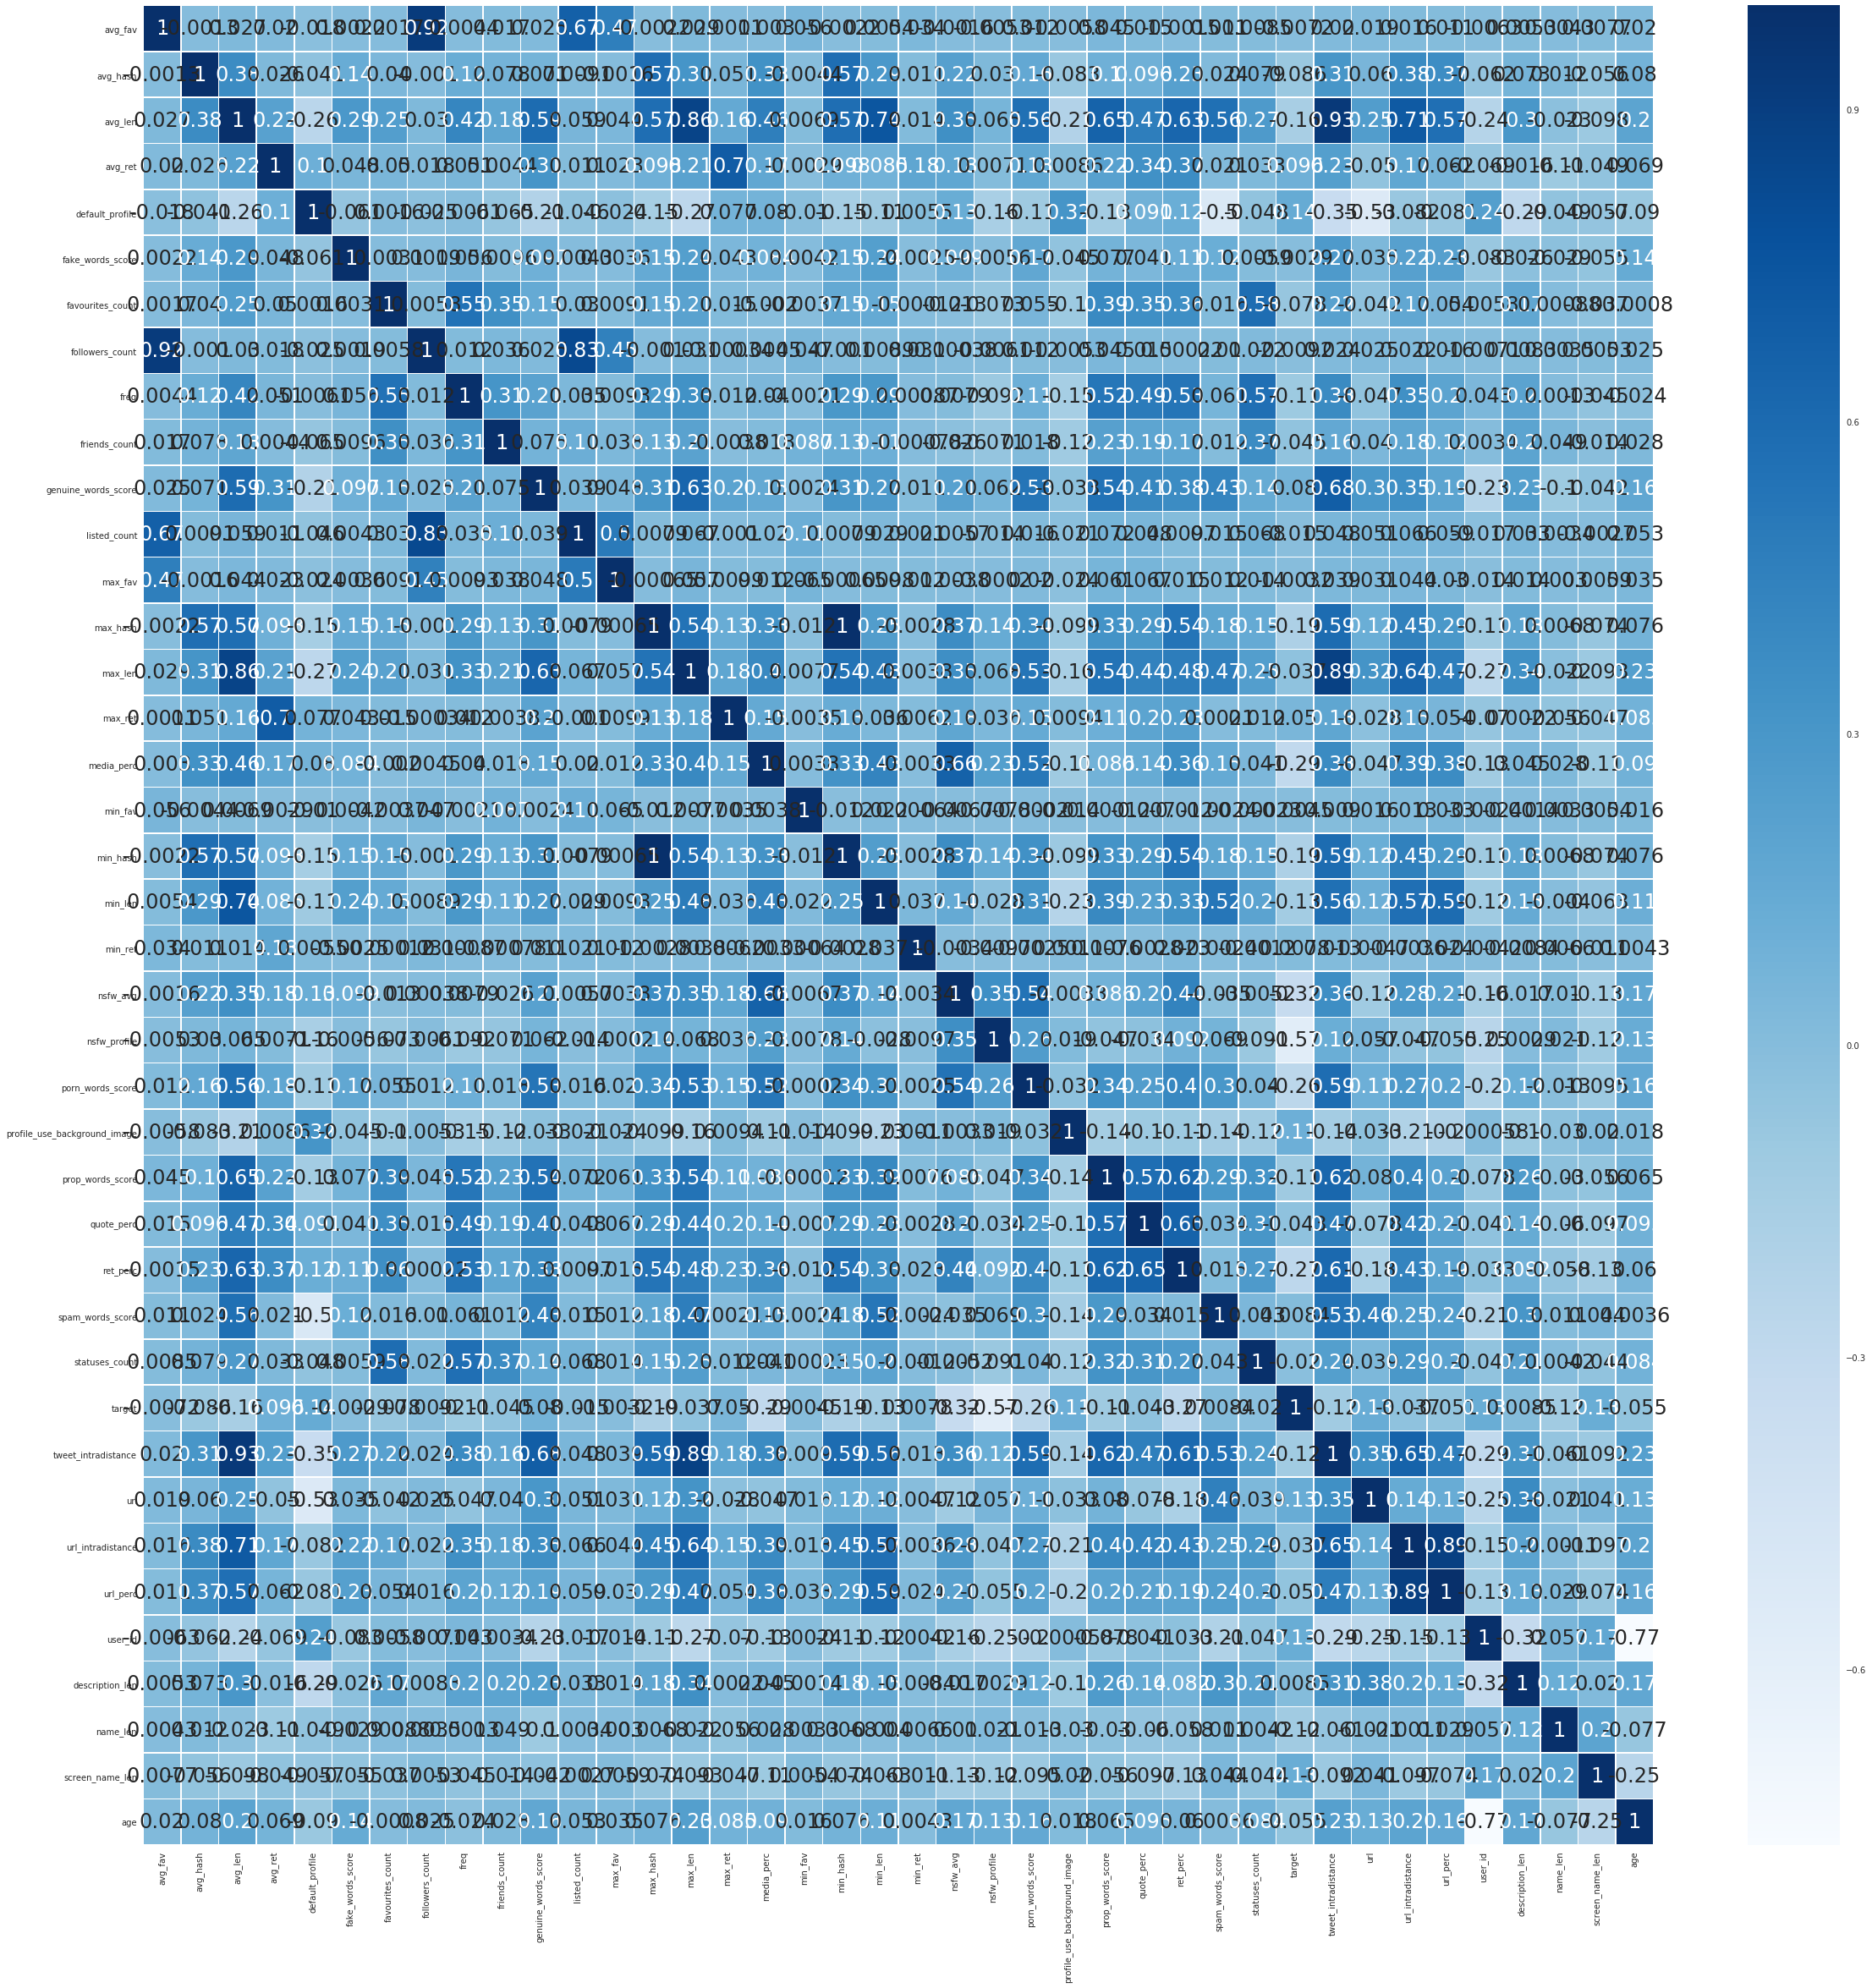

In [263]:
fig, ax = plt.subplots(figsize=(40,40))
cov=full.corr(method='pearson')
sns.heatmap(cov,annot=True,cmap="Blues",linewidths=.5, ax=ax)

In [264]:
cov['target'].sort_values(ascending=False)

target                          1.000000
default_profile                 0.138130
url                             0.129940
screen_name_len                 0.125824
user_id                         0.125303
profile_use_background_image    0.107442
avg_ret                         0.095802
genuine_words_score             0.079692
max_ret                         0.049879
description_len                 0.008477
spam_words_score                0.008449
min_ret                         0.007841
fake_words_score               -0.002902
max_fav                        -0.003242
min_fav                        -0.004518
avg_fav                        -0.007160
followers_count                -0.009184
listed_count                   -0.015293
statuses_count                 -0.019816
url_intradistance              -0.037171
max_len                        -0.037492
quote_perc                     -0.042583
friends_count                  -0.044566
url_perc                       -0.051026
age             

In [265]:
full.columns

Index(['avg_fav', 'avg_hash', 'avg_len', 'avg_ret', 'default_profile',
       'fake_words_score', 'favourites_count', 'followers_count', 'freq',
       'friends_count', 'genuine_words_score', 'listed_count', 'max_fav',
       'max_hash', 'max_len', 'max_ret', 'media_perc', 'min_fav', 'min_hash',
       'min_len', 'min_ret', 'nsfw_avg', 'nsfw_profile', 'porn_words_score',
       'profile_background_color', 'profile_link_color',
       'profile_sidebar_border_color', 'profile_sidebar_fill_color',
       'profile_text_color', 'profile_use_background_image',
       'prop_words_score', 'quote_perc', 'ret_perc', 'spam_words_score',
       'statuses_count', 'target', 'tweet_intradistance', 'url',
       'url_intradistance', 'url_perc', 'user_id', 'description_len',
       'name_len', 'screen_name_len', 'age'],
      dtype='object')

# riparti da qui per evitare preprocessing

In [266]:
full.to_csv('data/full/rf_preproc_train.csv', index=False)

In [267]:
# full = pd.read_csv('data/full/rf_preproc_train.csv')

full['context_sum'] = full['porn_words_score'] + full['prop_words_score'] + full['spam_words_score'] + full['fake_words_score'] + full['genuine_words_score']
full['porn_words_score'] = full['porn_words_score'] / full['context_sum']
full['prop_words_score'] = full['prop_words_score'] / full['context_sum']
full['spam_words_score'] = full['spam_words_score'] / full['context_sum']
full['fake_words_score'] = full['fake_words_score'] / full['context_sum']
full['genuine_words_score'] = full['genuine_words_score'] / full['context_sum']

full['porn_words_score'] = full['porn_words_score'].fillna(0.2)
full['prop_words_score'] = full['prop_words_score'].fillna(0.2)
full['spam_words_score'] = full['spam_words_score'].fillna(0.2)
full['fake_words_score'] = full['fake_words_score'].fillna(0.2)
full['genuine_words_score'] = full['genuine_words_score'].fillna(0.2)
full.drop(columns=['Unnamed: 0'], inplace=True)

In [268]:
def predict(X, y, n_trees=5, max_depth=None, knn=10):
    
    forest = RandomForestClassifier(n_estimators = n_trees, max_depth=max_depth, criterion = 'entropy', random_state = 42)
    logreg = linear_model.LogisticRegression()
    
    scaler = MinMaxScaler()
    X_n = scaler.fit_transform(X)
    knn = KNeighborsClassifier(n_neighbors=knn)
    scoring = ['f1_macro', 'precision_macro', 'recall_macro']
    scores = []
    scores.append(cross_validate(forest, X, y, cv=10, scoring=scoring))
    scores.append(cross_validate(logreg, X, y, cv=10, scoring=scoring))
    scores.append(cross_validate(knn, X_n, y, cv=10, scoring=scoring))
    
    return scores

In [269]:
# only our descriptive features
X = full[['avg_fav', 'avg_hash', 'avg_len', 'avg_ret',
       'freq', 'max_fav', 'max_hash', 'max_len', 'max_ret', 'media_perc', 'min_fav', 'min_hash',
       'min_len', 'min_ret', 'quote_perc',
       'ret_perc', 'url_perc', 'description_len', 'name_len', 'screen_name_len', 'age']]
y = full['target']

In [163]:
predict(X,y)

KeyboardInterrupt: 

In [ ]:
forest.fit(X,y)
sorted(zip(map(lambda x: round(x, 4), forest.feature_importances_), X.columns), reverse=True)

In [ ]:
# only context features
X = full[['fake_words_score', 'genuine_words_score', 'porn_words_score', 'prop_words_score', 'spam_words_score']]
y = full['target']

In [ ]:
predict(X,y)

In [ ]:
forest.fit(X,y)
sorted(zip(map(lambda x: round(x, 4), forest.feature_importances_), X.columns), reverse=True)

In [ ]:
# only intradistance features
X = full[['tweet_intradistance', 'url_intradistance']]
y = full['target']

In [ ]:
predict(X,y, n_trees=10, max_depth=None, knn=15)

In [ ]:
forest.fit(X,y)
sorted(zip(map(lambda x: round(x, 4), forest.feature_importances_), X.columns), reverse=True)

In [ ]:
# context + intradistance
X = full[['fake_words_score', 'genuine_words_score', 'porn_words_score', 'prop_words_score', 'spam_words_score', 'tweet_intradistance', 'url_intradistance']]
y = full['target']

In [ ]:
predict(X,y, n_trees=5, max_depth=None, knn=10)

In [ ]:
predict(X,y, n_trees=10, max_depth=None, knn=7)

In [ ]:
forest.fit(X,y)
sorted(zip(map(lambda x: round(x, 4), forest.feature_importances_), X.columns), reverse=True)

In [ ]:
# our features 
X = full[['avg_fav', 'avg_hash', 'avg_len', 'avg_ret',
       'fake_words_score', 'freq',
       'genuine_words_score', 'max_fav',
       'max_hash', 'max_len', 'max_ret', 'media_perc', 'min_fav', 'min_hash',
       'min_len', 'min_ret', 'porn_words_score',
       'prop_words_score', 'quote_perc',
       'ret_perc', 'spam_words_score',
       'tweet_intradistance', 'url', 'url_intradistance', 'url_perc',
       'description_len', 'name_len', 'screen_name_len', 'age']]
y = full['target']

In [ ]:
predict(X,y, n_trees=5, max_depth=None, knn=10)

In [ ]:
predict(X,y, n_trees=10, max_depth=None, knn=8)

In [ ]:
forest.fit(X,y)
sorted(zip(map(lambda x: round(x, 4), forest.feature_importances_), X.columns), reverse=True)

In [ ]:
# only default features
X = full[['default_profile', 'favourites_count', 'followers_count',
       'friends_count', 'listed_count', 'profile_use_background_image', 'statuses_count', 'url', 'verified'
         ]]
y = full['target']

In [ ]:
predict(X,y, n_trees=5, max_depth=None, knn=10)

In [ ]:
predict(X,y, n_trees=10, max_depth=None, knn=7)

In [ ]:
forest.fit(X,y)
sorted(zip(map(lambda x: round(x, 4), forest.feature_importances_), X.columns), reverse=True)

In [270]:
# all features except colors
X = full[['avg_fav', 'avg_hash', 'avg_len', 'avg_ret', 'default_profile',
       'fake_words_score', 'favourites_count', 'followers_count', 'freq',
       'friends_count', 'genuine_words_score', 'listed_count', 'max_fav',
       'max_hash', 'max_len', 'max_ret', 'media_perc', 'min_fav', 'min_hash',
       'min_len', 'min_ret', 'porn_words_score',
       'profile_use_background_image', 'prop_words_score', 'quote_perc',
       'ret_perc', 'spam_words_score', 'statuses_count',
       'tweet_intradistance', 'url', 'url_intradistance', 'url_perc',
       'description_len', 'name_len', 'screen_name_len', 'age', 'nsfw_avg', 'nsfw_profile']]

In [271]:
y = full['target']

In [88]:
predict(X,y, n_trees=5, max_depth=None, knn=10)

/home/matteo/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_f1_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/matteo/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_precision_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/matteo/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_recall_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


[{'fit_time': array([0.30644608, 0.29206276, 0.28080201, 0.29739714, 0.29727936,
         0.29195929, 0.30034065, 0.31465793, 0.30776501, 0.27830601]),
  'score_time': array([0.0078969 , 0.00744748, 0.00730538, 0.00739217, 0.00725412,
         0.00735307, 0.00751948, 0.0074451 , 0.00749016, 0.00764394]),
  'test_f1_macro': array([0.85236242, 0.95646131, 0.96029237, 0.96391579, 0.96859479,
         0.94408028, 0.92471276, 0.94325384, 0.94157202, 0.78295214]),
  'train_f1_macro': array([0.99484824, 0.99417046, 0.99515995, 0.99419811, 0.99506744,
         0.99498569, 0.99441232, 0.99398469, 0.99430246, 0.99638966]),
  'test_precision_macro': array([0.86147393, 0.95813316, 0.96221407, 0.96609996, 0.96956744,
         0.9480862 , 0.92146316, 0.94653953, 0.94565099, 0.80358098]),
  'train_precision_macro': array([0.9952099 , 0.99453447, 0.99578375, 0.99457769, 0.99544052,
         0.99528462, 0.99463485, 0.99429524, 0.99469667, 0.99662844]),
  'test_recall_macro': array([0.87618437, 0.955646

In [89]:
scores = predict(X,y, n_trees=15, max_depth=None, knn=7)

KeyboardInterrupt: 

## RF scores:

In [ ]:
print("F1:")
print(scores[0]['test_f1_macro'].mean())
print("Precision:")
print(scores[0]['test_precision_macro'].mean())
print("Recall:")
print(scores[0]['test_recall_macro'].mean())

## KNN scores:

In [52]:
print("F1:")
print(scores[2]['test_f1_macro'].mean())
print("Precision:")
print(scores[2]['test_precision_macro'].mean())
print("Recall:")
print(scores[2]['test_recall_macro'].mean())

F1:
0.8344511371885762
Precision:
0.8550325230230722
Recall:
0.8363502687683884


## Grid Search

In [44]:
def grid_search(X, y, model, params):
    
    scoring = ['f1_macro', 'precision_macro', 'recall_macro']
    grid = GridSearchCV(model, params, cv=10, scoring=scoring, refit='f1_macro')
    grid.fit(X, y)
    
    return grid

### KNN

In [121]:
params = {'n_neighbors':[5,7,10,15,20]}
model = knn = KNeighborsClassifier()
scaler = MinMaxScaler()
X_n = scaler.fit_transform(X)

knn_grid = grid_search(X_n, y, model, params)

In [126]:
import pandas as pd

In [130]:
knn_grid.best_params_

{'n_neighbors': 5}

In [135]:
knn_df = pd.DataFrame(knn_grid.cv_results_)

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_f1_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_f1_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_f1_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anac

In [137]:
knn_df.loc[1]

mean_fit_time                              0.54654
std_fit_time                                0.2335
mean_score_time                            3.86909
std_score_time                             1.05851
param_n_neighbors                                7
params                          {'n_neighbors': 7}
split0_test_f1_macro                      0.729459
split1_test_f1_macro                      0.816879
split2_test_f1_macro                      0.901592
split3_test_f1_macro                      0.890983
split4_test_f1_macro                      0.885432
split5_test_f1_macro                       0.89586
split6_test_f1_macro                      0.799091
split7_test_f1_macro                      0.861996
split8_test_f1_macro                      0.855926
split9_test_f1_macro                      0.693406
mean_test_f1_macro                        0.833045
std_test_f1_macro                        0.0691059
rank_test_f1_macro                               3
split0_train_f1_macro          

### Random Forest

In [47]:
params = {'n_estimators':[15,20,25,30,35,40,45], 'max_depth':[20, 22, 24, 26, 28, 30], 'criterion': ['gini', 'entropy']}
model = RandomForestClassifier()

rf_grid = grid_search(X, y, model, params)

In [48]:
rf_df = pd.DataFrame(rf_grid.cv_results_)

/home/matteo/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_f1_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/matteo/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_f1_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/matteo/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_f1_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/matteo/anaconda3

In [49]:
rf_grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=28, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [78]:
rf_df.sort_values(['mean_test_f1_macro'],ascending=False).iloc[0].params

{'criterion': 'gini', 'max_depth': 28, 'n_estimators': 40}

In [50]:
results = rf_grid.cv_results_

In [52]:
results['mean_test_f1_macro'].max()

0.9441032732460334

/home/matteo/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


NameError: name 'sample' is not defined

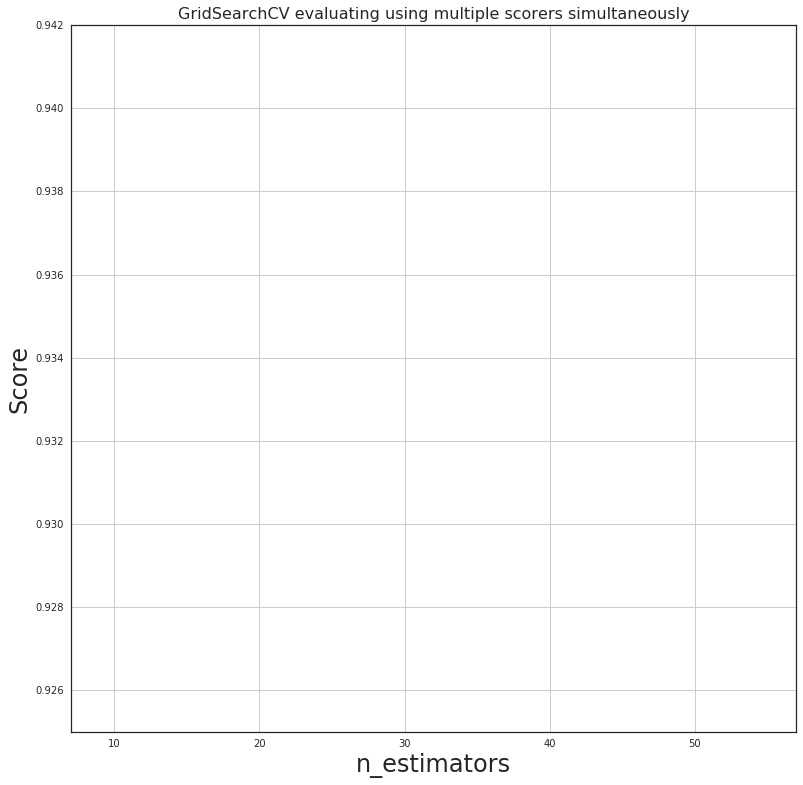

In [96]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(7, 57)
ax.set_ylim(0.925, 0.942)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_n_estimators'].data, dtype=float)

scoring = ['f1_macro', 'precision_macro', 'recall_macro']

for score, color in zip(sorted(scoring), ['b', 'r', 'g']):
    sample_score_mean_gini = results['mean_%s_%s' % ('test', score)][:10]
    sample_score_mean_entropy = results['mean_%s_%s' % ('test', score)][10:]
    crit = results['param_criterion']
    ax.plot(X_axis[:10], sample_score_mean_gini, color=color,
            alpha=1 if sample == 'test' else 0.7,
            linestyle='--',
            label="%s (%s) - %s" % (score, sample, 'gini'))
    ax.plot(X_axis[10:], sample_score_mean_entropy, color=color,
            alpha=1 if sample == 'test' else 0.7,
            label="%s (%s) - %s" % (score, sample, 'entropy'))
 
    best_index = np.nonzero(results['rank_test_' + score] == 1)[0][0]
    best_score = results['mean_test_' + score].max()

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.3f" % best_score,
                (X_axis[best_index]+1, best_score + 0.0005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

### Max depth tuning

In [285]:
X.columns

Index(['avg_fav', 'avg_hash', 'avg_len', 'avg_ret', 'default_profile',
       'fake_words_score', 'favourites_count', 'followers_count', 'freq',
       'friends_count', 'genuine_words_score', 'listed_count', 'max_fav',
       'max_hash', 'max_len', 'max_ret', 'media_perc', 'min_fav', 'min_hash',
       'min_len', 'min_ret', 'porn_words_score',
       'profile_use_background_image', 'prop_words_score', 'quote_perc',
       'ret_perc', 'spam_words_score', 'statuses_count', 'tweet_intradistance',
       'url', 'url_intradistance', 'url_perc', 'description_len', 'name_len',
       'screen_name_len', 'oldness'],
      dtype='object')

In [287]:
params = {'n_estimators':[30], 'max_depth':list(range(1,len(X.columns), 3)), 'criterion': ['gini']}
model = RandomForestClassifier()

rf_grid_depth = grid_search(X, y, model, params)

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Lorenzo/anaco

In [297]:
rf_drig_df = pd.DataFrame(rf_grid_depth.cv_results_)

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_f1_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_f1_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_f1_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anac

In [289]:
rf_grid_depth.best_params_

{'criterion': 'gini', 'max_depth': 22, 'n_estimators': 30}

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Series.data is deprecated and will be removed in a future version
  
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


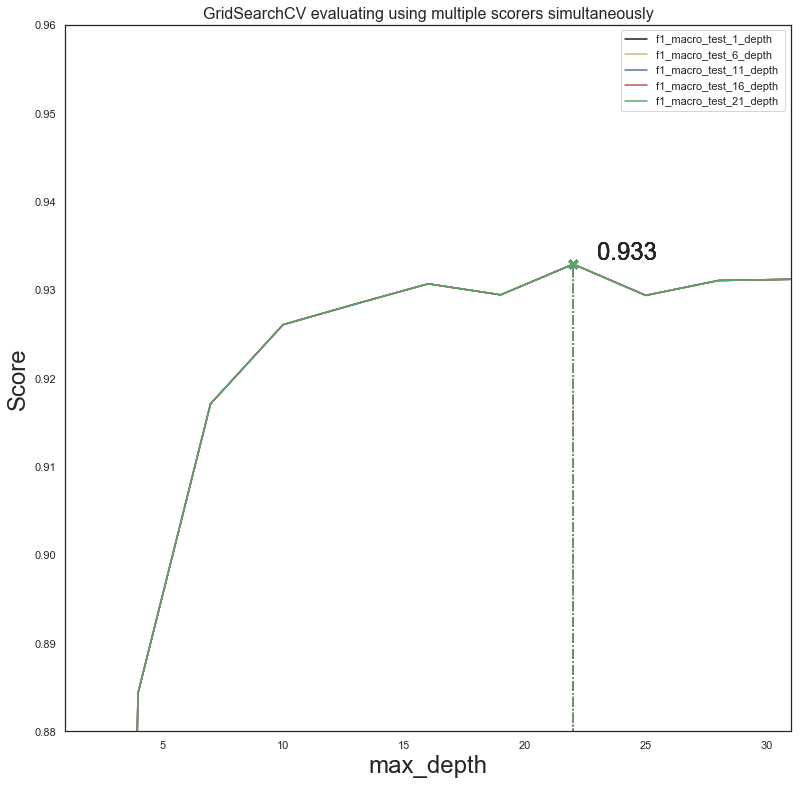

In [294]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("max_depth")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(1, 31)
ax.set_ylim(0.88, 0.96)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(rf_drig_df['param_max_depth'].data, dtype=float)

depth = range(1,len(X.columns), 5)

for d, color in zip(depth, ['k', 'y', 'b', 'r', 'g']):
    sample_score = rf_drig_df['mean_test_f1_macro']
    ax.plot(X_axis, sample_score, color=color,
            alpha=1,
            linestyle='-',
            label="f1_macro_test_%s_depth " % d)
 
    best_index = np.nonzero(rf_drig_df['rank_test_f1_macro'] == 1)[0][0]
    best_score = rf_drig_df['mean_test_f1_macro'].max()

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.3f" % best_score,
                (X_axis[best_index]+1, best_score + 0.0005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

In [295]:
params = {'n_estimators':[20,25,30,35,40], 'max_depth':list(range(15,30,3)), 'criterion': ['gini']}
model = RandomForestClassifier()

rf_grid_depth = grid_search(X, y, model, params)

In [ ]:
rf_grid_depth = grid_search(X, y, model, params)

In [296]:
rf_grid_depth.best_params_

{'criterion': 'gini', 'max_depth': 27, 'n_estimators': 40}

In [326]:
X_axis

array([20., 25., 30., 35., 40., 20., 25., 30., 35., 40., 20., 25., 30.,
       35., 40., 20., 25., 30., 35., 40., 20., 25., 30., 35., 40.])

In [101]:
rf_drig_df = pd.DataFrame(results)

/home/matteo/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_f1_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/matteo/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_f1_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/matteo/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_f1_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/matteo/anaconda3

/home/matteo/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/matteo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Series.data is deprecated and will be removed in a future version
/home/matteo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Series.data is deprecated and will be removed in a future version
/home/matteo/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (

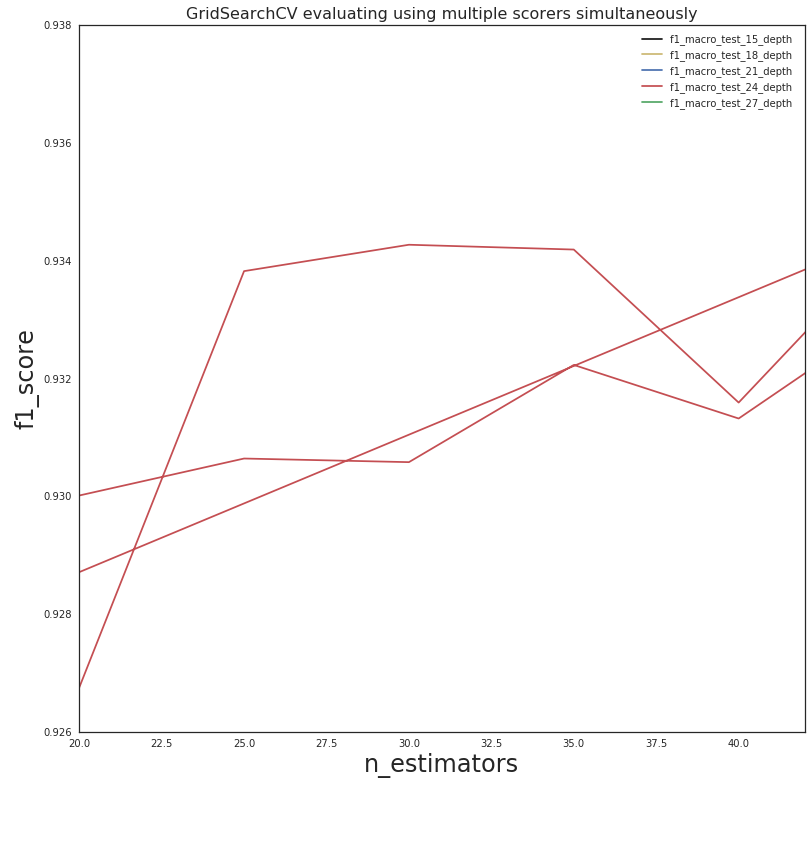

In [102]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("n_estimators")
plt.ylabel("f1_score")
plt.grid()

ax = plt.axes()
ax.set_xlim(20, 42)
ax.set_ylim(0.926, 0.938)

depth = range(15,30,3)

for d, color in zip(depth, ['k', 'y', 'b', 'r', 'g']):
    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(rf_drig_df[rf_drig_df['param_max_depth'] == d]['param_n_estimators'].data, dtype=float)
    sample_score = rf_drig_df[rf_drig_df['param_max_depth'] == d]['mean_test_f1_macro']
    ax.plot(X_axis, sample_score, color=color,
            linestyle='-',
            label="f1_macro_test_%s_depth " % d)
    

best_index = np.nonzero(rf_drig_df['rank_test_f1_macro'] == 1)[0][0]
best_score = rf_drig_df['mean_test_f1_macro'].max()
X_axis = np.array(rf_drig_df['param_n_estimators'].data, dtype=float)
# Plot a dotted vertical line at the best score for that scorer marked by x
ax.plot([X_axis[best_index], ] * 2, [0, best_score],
        linestyle='-.', color='k', marker='x', markeredgewidth=3, ms=8)

# Annotate the best score for that scorer
ax.annotate("%0.3f" % best_score,
            (X_axis[best_index], best_score + 0.0005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

In [272]:
model = RandomForestClassifier(n_estimators=60, criterion='gini', max_depth=28)

In [273]:
model.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=28, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [274]:
pickle.dump(model, open("../scripts/models/rf.model", "wb"))

In [275]:
model = pickle.load(open("../scripts/models/rf.model", "rb"))

In [276]:
forest = model
scoring = ['f1_macro', 'precision_macro', 'recall_macro']
scores = []
scores.append(cross_validate(forest, X, y, cv=10, scoring=scoring))
#scores.append(cross_validate(logreg, X, y, cv=10, scoring=scoring))
#scores.append(cross_validate(knn, X_n, y, cv=10, scoring=scoring))

In [277]:
scores[0]['test_f1_macro'].mean()

0.943975012986866

In [161]:
0.943067123324459

0.943067123324459